**Neural Machine Translation using Pytorch**

---



In this project we will be creating a neural network to translate from French to English.

In [ ]:
!pip install bcolz

First We import all the necessary libraries including pytorch


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import bcolz 
import pickle
import copy
import operator

import torch 
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import numpy as np
import pandas as pd

The Model is being trained on the google colab. We import drive inorder to use data directly from the google drive 


The data we are using can be directly downloaded here https://download.pytorch.org/tutorial/data.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


We are using a pre-trained word vectors - GLOVE(Global Vectors for Word Representation). It can be downloaded from here hhttps://nlp.stanford.edu/projects/glove/

In [ ]:
words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir=f'/content/drive/My Drive/glove.6B/6B.50.dat', mode='w')
 
with open(f'/content/drive/My Drive/glove.6B/glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
     
vectors = bcolz.carray(vectors[1:].reshape((400000, 50)), rootdir=f'/content/drive/My Drive/glove.6B/6B.50.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'/content/drive/My Drive/glove.6B/6B.50_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'/content/drive/My Drive/glove.6B/6B.50_idx.pkl', 'wb'))

In [ ]:
vectors = bcolz.open(f'/content/drive/My Drive/glove.6B/6B.50.dat')[:]
words = pickle.load(open(f'/content/drive/My Drive/glove.6B/6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(f'/content/drive/My Drive/glove.6B/6B.50_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

We are using a 50 dimensional vector format in glove. The following data frame shows the weights of few characters

In [ ]:
glove_dframe = pd.DataFrame(vectors, columns=range(1,51), index=words)
glove_dframe[100:110]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
so,0.60308,-0.320240,0.088857,-0.551760,0.531820,0.047069,-0.36246,0.005702,-0.37665,0.225340,-0.13534,0.359880,-0.425180,0.071324,0.770650,0.567120,0.41226,0.124510,0.142300,-0.96535,-0.390530,0.341990,0.56969,0.031635,0.694650,-1.9216,-0.671180,0.57971,0.860880,-0.591050,3.7787,0.304310,-0.043103,-0.42398,-0.063915,-0.066822,0.061983,0.563320,-0.223350,-0.47386,-0.470210,0.091714,0.147780,0.638050,-0.143560,-0.002293,-0.315000,-0.251870,-0.268790,0.36657
them,0.64642,-0.556000,0.470380,-0.820740,0.795120,0.287710,-0.56426,0.146300,-0.52421,0.021607,-0.11266,0.319860,-0.057542,-0.233750,0.637030,0.338200,0.46490,-0.423980,0.091868,-0.88040,0.220770,0.712700,0.98196,-0.033819,0.315540,-1.8001,-0.260030,-0.37762,0.856340,-1.339300,3.6408,0.872730,-0.792300,-0.51268,0.144150,0.554390,0.100600,0.132330,-0.071904,-0.16399,-0.089989,-0.031932,0.613900,0.404190,0.226860,-0.189740,-0.554030,-0.358310,-0.109950,-0.44700
what,0.45323,0.059811,-0.105770,-0.333000,0.723590,-0.087170,-0.61053,-0.037695,-0.30945,0.218050,-0.43605,0.473180,-0.768660,-0.271300,1.104200,0.591410,0.56962,-0.186780,0.148670,-0.67292,-0.346720,0.522840,0.22959,-0.072014,0.939670,-2.3985,-1.323800,0.28698,0.755090,-0.765220,3.3425,0.172330,-0.518030,-0.82970,-0.293330,-0.500760,-0.152280,0.098973,0.181460,-0.17420,-0.406660,0.203480,-0.011788,0.482520,0.024598,0.340640,-0.084724,0.532400,-0.251030,0.62546
him,0.11964,-0.045405,0.051100,-0.828730,0.976650,0.111280,-0.54588,1.156100,-0.68081,0.060207,-0.28765,0.880610,-0.917950,-0.183280,0.841840,-0.118560,-0.14957,-0.161550,-0.374060,-0.45342,-0.185170,1.039200,0.55667,-0.143090,0.713940,-2.9407,-0.051859,-0.13871,0.321510,-0.979710,2.9054,0.534260,-0.814180,-0.48852,0.011175,0.422110,0.390040,0.452430,-0.007067,-0.64889,0.091121,0.468900,-0.581920,0.456540,0.027340,-0.445390,-0.423730,-0.627920,0.024592,-0.14341
united,-0.39874,0.071993,-0.069773,0.147060,0.118500,0.147700,-0.84431,0.147600,0.64804,-0.559260,0.50164,-0.073356,-0.412910,-0.536110,0.001539,0.130580,0.41344,-0.469950,-0.395550,0.31692,0.142350,-0.027840,0.15000,0.046728,-0.484600,-2.1998,0.956550,-0.52361,-0.249620,0.071318,3.2888,0.203260,-0.382280,-0.66121,-0.137100,-0.769120,-0.099412,0.212310,-0.990460,-0.48150,0.059310,-0.289030,0.922230,-0.907380,-0.053878,1.055700,-0.983100,0.167570,-0.816590,-0.12107
during,0.29784,-0.018422,-0.718910,-0.465100,-0.456610,-0.004215,-0.74598,0.346620,-0.51781,-0.587700,0.18398,-0.369030,-0.522250,-0.140820,0.834460,-0.269620,-0.89364,-0.118130,-1.307600,0.47500,0.528150,-0.021974,0.61869,-0.653620,-0.142980,-1.6466,-0.053050,-0.17046,0.170480,0.757560,3.5832,0.137750,-0.378110,-0.48736,0.006991,0.599130,0.314040,0.307340,-0.423970,0.35383,-0.971510,0.160820,-0.636660,-0.204490,-0.070846,-0.322190,-0.049254,-0.418650,-0.689900,-0.54908
before,0.30806,-0.296650,-0.257060,-0.587100,0.095135,-0.152110,-0.91478,0.757270,-0.30423,-0.290580,-0.13034,-0.100950,-0.897550,-0.004783,0.800600,0.169630,-0.50634,-0.658420,-1.133900,-0.11095,0.654180,0.353780,0.63650,-0.300830,0.026192,-1.9383,0.690730,0.17019,0.199220,-0.393070,3.4795,0.325460,-0.763140,-0.15125,0.181690,-0.007695,0.555250,0.561420,0.279700,-0.12891,-0.390370,0.004439,-0.323670,0.009888,-0.378660,0.300180,0.208750,-0.538440,-0.110580,-0.54785
may,0.70480,0.222610,0.086997,-0.212410,-0.089356,0.437420,-0.28170,0.133780,-0.50859,-0.182420,0.49506,0.424610,0.046785,-0.501210,0.846210,1.014600,-0.43954,-0.654990,-0.647060,-0.23365,0.276120,-0.632940,0.91064,0.033327,-0.058451,-1.6059,-0.347410,-0.36285,0.467230,0.244000,3.4249,0.056168,-0.719910,-0.88332,0.337410,-0.532360,0.339910,0.023837,0.238400,-0.38713,-0.496210,-0.148460,0.046201,0.103250,0.173740,0.137630,0.084989,-0.396880,0.176320,0.31862
since,0.15423,-0.125520,0.022279,-0.067561,-0.359750,0.144090,-1.09020,-0.028693,-0.43147,-0.137810,0.37841,-0.630310,-0.9552

It is seq2seq model using attention. We gonna first create function to form word to index and index to word and add SOS [Start of Sentence] and EOS [End of a Sentence] tokens to each sentences.

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In this following step we gonna normalize the string by coverting all to a lower case letters and remove punctuations using regural expressions library

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

The next step is we gonna read lines from the data from the drive which are seperated by tab space are split into two categories (for eg: lang1 = English, lang2 = French). Then we are gonna shrink the data to maximum size of 10.

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/content/drive/My Drive/Colab Notebooks/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Finally, the prerocessing steps are applied to the data.

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis votre debiteur .', 'i am in your debt .']


The weight vectors defined by glove are applied to our actual data

In [ ]:
matrix_len = input_lang.n_words

weights_matrix = np.zeros((matrix_len, 50))
words_found = 0

for i, word in enumerate(input_lang.word2index):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(50, ))

The seq2seq model contains two RNN's - Encoder and Decoder.
First let us create the Encoder RNN.

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Then the Decoder RNN is created and attention weights are applied to output of encoder.


In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Training the model

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Teacher forcing approach is followed with 50% ratio. We use the exact target as the input in decoder.

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting the result

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Creating a function for evaluation.

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


We are gonna use a hidden size of 256 neurons and start the training by calling the functions.

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

2m 24s (- 33m 38s) (5000 6%) 2.8444
4m 41s (- 30m 30s) (10000 13%) 2.2577
6m 59s (- 27m 58s) (15000 20%) 1.9638
9m 17s (- 25m 34s) (20000 26%) 1.7077
11m 34s (- 23m 9s) (25000 33%) 1.5138
13m 52s (- 20m 48s) (30000 40%) 1.3361
16m 9s (- 18m 27s) (35000 46%) 1.2093
18m 25s (- 16m 7s) (40000 53%) 1.0830
20m 41s (- 13m 47s) (45000 60%) 0.9718
22m 55s (- 11m 27s) (50000 66%) 0.8745
25m 10s (- 9m 9s) (55000 73%) 0.8046
27m 25s (- 6m 51s) (60000 80%) 0.7194
29m 41s (- 4m 34s) (65000 86%) 0.6613
31m 57s (- 2m 16s) (70000 93%) 0.5887
34m 11s (- 0m 0s) (75000 100%) 0.5660


A sample Evaluation shows the accuracy of the model. We can see that it has working almost perfectly.

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

> c est mon meilleur ami .
= he s my best friend .
< he is my best friend . <EOS>

> ce n est pas un saint .
= he s no saint .
< he s no a . <EOS>

> tu es une merveilleuse amie .
= you re a wonderful friend .
< you re a wonderful friend . <EOS>

> c est par nature une personne genereuse .
= he is by nature a generous person .
< he is certain by a a person person . <EOS>

> j en ai marre de tes plaintes .
= i m getting tired of your complaints .
< i m sick of your complaints . <EOS>

> je suis accoutume a travailler toute la nuit .
= i m used to working all night .
< i m used to working all night . <EOS>

> elle est facile a vivre .
= she is easygoing .
< she is easygoing . <EOS>

> elle est privee de sortie .
= she is forbidden to go out .
< she is loved to go . <EOS>

> c est vous le plus vieux .
= you re the oldest .
< you re the oldest . <EOS>

> vous etes degoutantes .
= you re disgusting .
< you re disgusting . <EOS>



In [ ]:
%matplotlib inline

The following plot shows the attentions applied to each word.

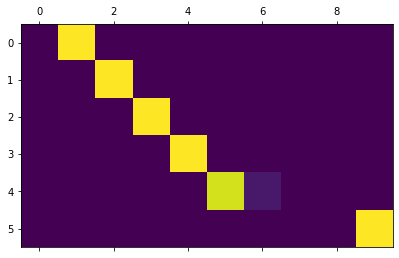

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


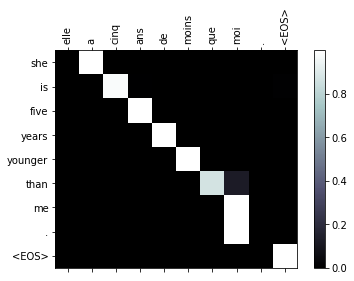

input = elle est trop petit .
output = she s too loud . <EOS>


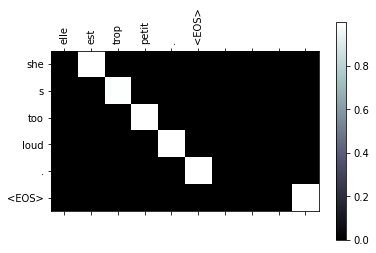

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


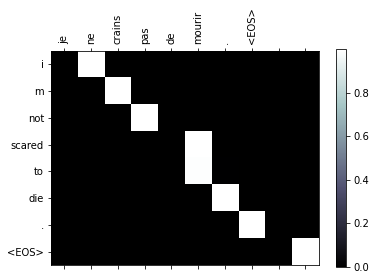

input = c est un jeune directeur plein de talent .
output = he s a talented young young . <EOS>


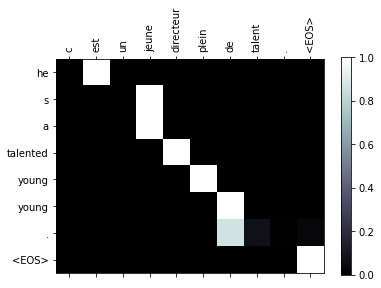

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")